# **Stock Line Prediction With LSTM**

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data
import datetime
import warnings
warnings.filterwarnings("ignore")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Loading Data**

In [9]:
df= pd.read_csv('/content/drive/MyDrive/Stock_Prediction_LSTM/NSE-TATAGLOBAL11.csv')

In [10]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

In [11]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-10-08,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


## **Closing Price vs Year**

Text(0.5, 1.0, 'Closing Price vs Year')

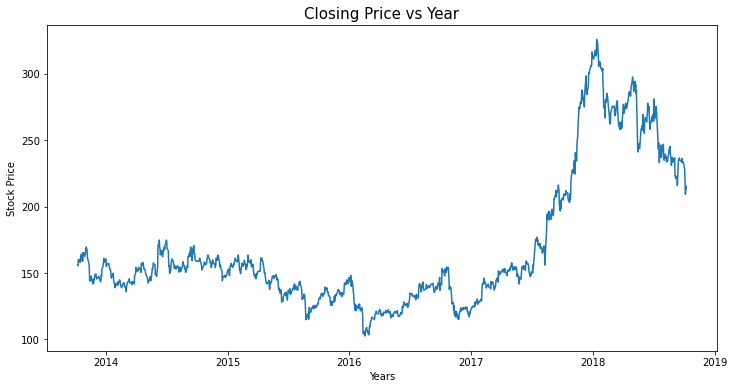

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price history')
plt.xlabel('Years')
plt.ylabel('Stock Price')
plt.title('Closing Price vs Year',fontsize=15)

In [14]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2013-10-14,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09
2013-10-11,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
2013-10-10,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
2013-10-09,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2013-10-08,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94


## **Closing price vs Year with 100 Moving Average (100MA)**

In [15]:
ma100=df.Close.rolling(100).mean()
ma100

Date
2018-10-08         NaN
2018-10-05         NaN
2018-10-04         NaN
2018-10-03         NaN
2018-10-01         NaN
                ...   
2013-10-14    150.0635
2013-10-11    150.2385
2013-10-10    150.4310
2013-10-09    150.5825
2013-10-08    150.7810
Name: Close, Length: 1235, dtype: float64

Text(0.5, 1.0, 'Closing price vs Year with 100MA')

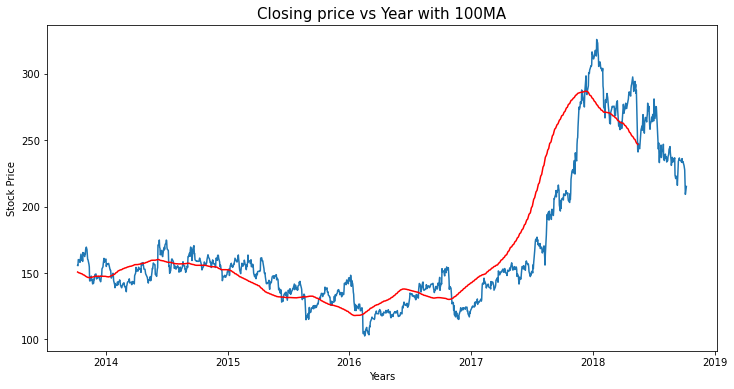

In [16]:
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.xlabel('Years')
plt.ylabel('Stock Price')
plt.title('Closing price vs Year with 100MA',fontsize=15)

## **Closing price vs Year with 200 Moving Average (200MA)**

In [25]:
ma200=df.Close.rolling(200).mean()
ma200

Date
2018-10-08          NaN
2018-10-05          NaN
2018-10-04          NaN
2018-10-03          NaN
2018-10-01          NaN
                ...    
2013-10-14    152.33475
2013-10-11    152.36350
2013-10-10    152.39675
2013-10-09    152.41000
2013-10-08    152.41300
Name: Close, Length: 1235, dtype: float64

Text(0.5, 1.0, 'Closing price vs Year with 200MA')

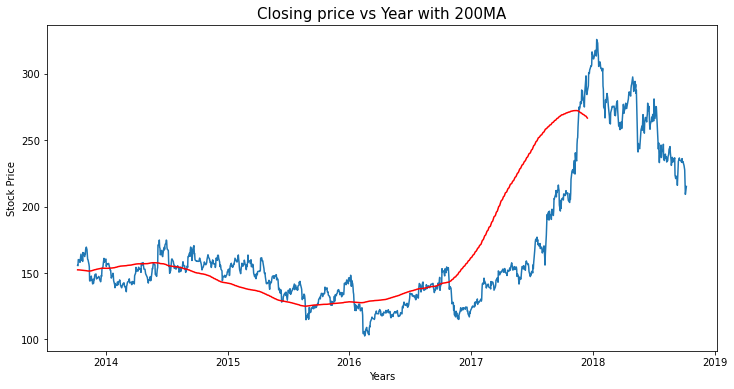

In [26]:
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma200,'r')
plt.xlabel('Years')
plt.ylabel('Stock Price')
plt.title('Closing price vs Year with 200MA',fontsize=15)

## **Closing Price vs Year with 100MA & 200MA**

Text(0.5, 1.0, 'Closing price vs Year with 100MA & 200MA')

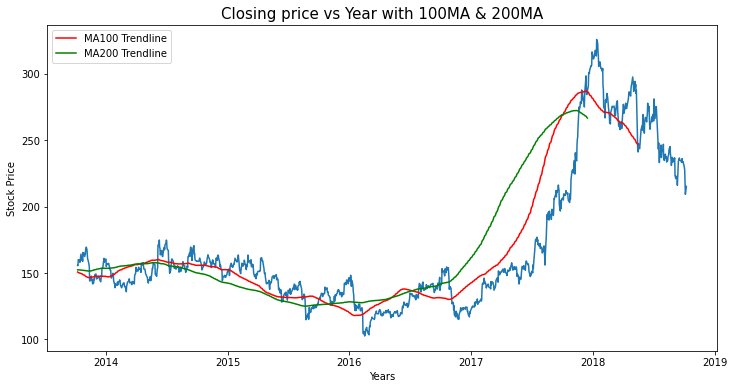

In [14]:
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100,'r',label='MA100 Trendline')
plt.plot(ma200,'g',label='MA200 Trendline')
plt.xlabel('Years')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Closing price vs Year with 100MA & 200MA',fontsize=15)

In [15]:
df.shape

(1235, 8)

In [27]:
data = df.sort_index(ascending=True, axis=0)

In [17]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2013-10-08,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
2013-10-09,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2013-10-10,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
2013-10-11,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
2013-10-14,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


In [28]:
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i]=data['Date'][i]
    new_data['Close'][i]=data['Close'][i]

In [19]:
new_data.head()

,Date,Close
0,2013-10-08 00:00:00,155.8
1,2013-10-09 00:00:00,155.55
2,2013-10-10 00:00:00,160.15
3,2013-10-11 00:00:00,160.05
4,2013-10-14 00:00:00,159.45


In [29]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [30]:
dataset = new_data.values

## **Train and Validation Data Split**

In [32]:
# Train Dataset=80%
# Test Dataset=20%
train = dataset[0:int((dataset.shape[0])*0.8),:]
valid = dataset[int((dataset.shape[0])*0.8):,:]

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [34]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

In [35]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [36]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [37]:
x_train.shape

(928, 60, 1)

## **LSTM Model**

In [28]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu',return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [30]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=50)

Epoch 1/50
29/29 [==============================] - 16s 292ms/step - loss: 0.0127
Epoch 2/50
29/29 [==============================] - 9s 296ms/step - loss: 0.0048
Epoch 3/50
29/29 [==============================] - 8s 291ms/step - loss: 0.0027
Epoch 4/50
29/29 [==============================] - 9s 292ms/step - loss: 0.0024
Epoch 5/50
29/29 [==============================] - 9s 299ms/step - loss: 0.0023
Epoch 6/50
29/29 [==============================] - 9s 306ms/step - loss: 0.0021
Epoch 7/50
29/29 [==============================] - 9s 306ms/step - loss: 0.0020
Epoch 8/50
29/29 [==============================] - 9s 324ms/step - loss: 0.0019
Epoch 9/50
29/29 [==============================] - 9s 300ms/step - loss: 0.0020
Epoch 10/50
29/29 [==============================] - 9s 299ms/step - loss: 0.0022
Epoch 11/50
29/29 [==============================] - 9s 294ms/step - loss: 0.0019
Epoch 12/50
29/29 [==============================] - 8s 293ms/step - loss: 0.0016
Epoch 13/50
29/29 [=====

In [38]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [39]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [40]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [35]:
X_test.shape

(247, 60, 1)

In [36]:
valid.shape

(247, 1)

In [41]:
closing_price = model.predict(X_test)

In [42]:
closing_price = scaler.inverse_transform(closing_price)

### **Root Mean Square Error**

In [39]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

10.64913255923967

## **Predictions vs Original Stock Line**

Text(0.5, 1.0, 'Predictions vs Original Stock Line')

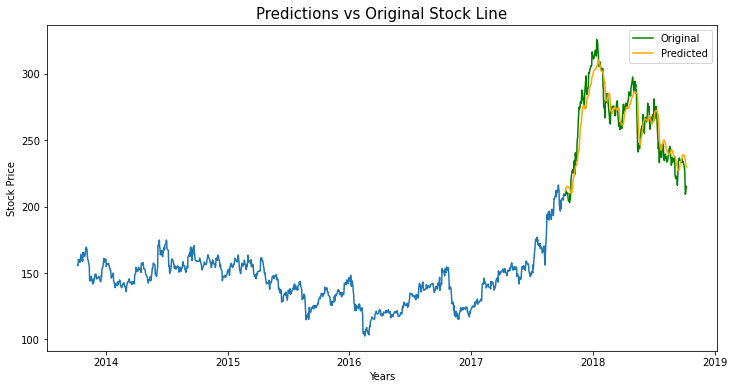

In [44]:
plt.figure(figsize=(12,6))
train = new_data[:int((dataset.shape[0])*0.8)]
valid = new_data[int((dataset.shape[0])*0.8):]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close']],label='Original',color='g')
plt.plot(valid[['Predictions']],label='Predicted',color='orange')
plt.xlabel('Years')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Predictions vs Original Stock Line',fontsize=15)

### **Saving the Model**

In [43]:
model.save('/content/drive/MyDrive/Stock_Prediction_LSTM/keras_model_stock_prediction_lstm_model.h5')